## Import libraries

In [299]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score
! pip install plotly
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

## Read file with labels

In [300]:
datsub= pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', datsub.shape)

Set with labels (our train+test) : (284580, 6)


In [301]:
# Basic statistics

print("Basics statistics: ")
data_desc = datsub.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*datsub.isnull().sum()/datsub.shape[0])
print()

Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000



Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

## Explore dataset

In [302]:
# Set up variabes for preprocessing and sample for EDA

sumup = datsub.sample(10000)
features_list = ['total_pages_visited']
numeric_indices = [0]
categorical_indices = []
target_variable = 'converted'

In [303]:
sumup.head()

,country,age,new_user,source,total_pages_visited,converted
43705,US,34,1,Ads,2,0
191829,China,35,1,Direct,1,0
205218,UK,19,1,Direct,3,0
184297,China,29,1,Ads,9,0
69008,US,30,1,Seo,1,0


In [304]:
sumup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 43705 to 92803
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   country              10000 non-null  object
 1   age                  10000 non-null  int64 
 2   new_user             10000 non-null  int64 
 3   source               10000 non-null  object
 4   total_pages_visited  10000 non-null  int64 
 5   converted            10000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 546.9+ KB


In [305]:
sumup['total_pages_visited'].unique()

array([ 2,  1,  3,  9,  4, 12, 10, 11,  8,  5,  7,  6, 13, 17, 18, 15, 16,
       14, 20, 21, 19, 23, 22, 24, 25, 26])

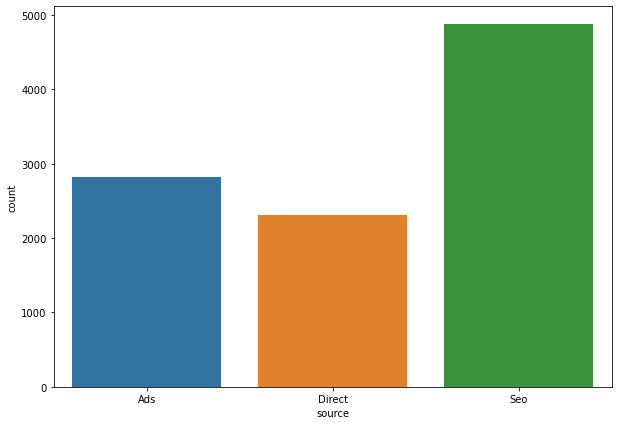

In [306]:
#define the figure and plot; modify the countplot figure size

countplt, ax = plt.subplots(figsize = (10,7))
ax =sns.countplot(x = 'source', data=sumup)

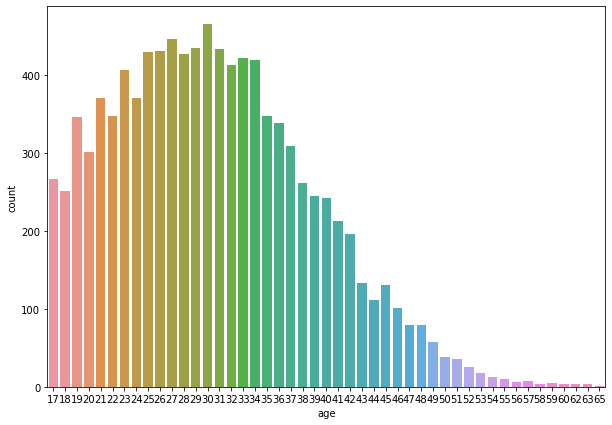

In [307]:
#define the figure and plot; modify the countplot figure size

countplt, ax = plt.subplots(figsize = (10,7))
ax =sns.countplot(x = 'age', data=sumup)

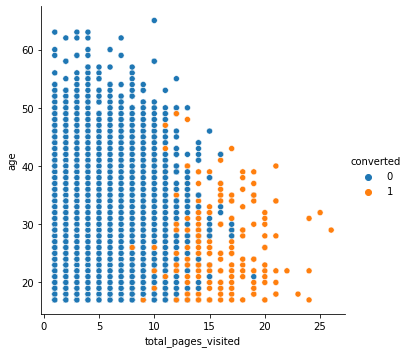

In [308]:
sns.relplot(x = 'total_pages_visited' , y = 'age' , data = sumup, hue = 'converted')

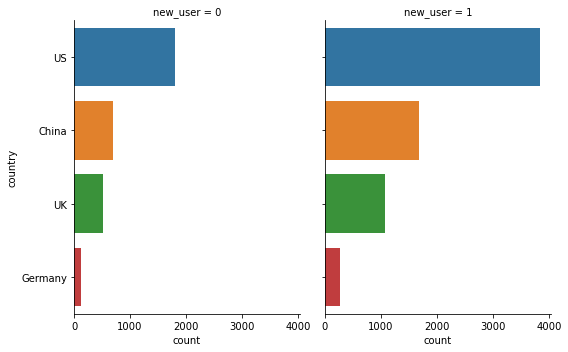

In [309]:
# new users per country

sns.catplot(y="country", col="new_user",
                data=sumup, kind="count",
                 height=5, aspect=0.8);

<AxesSubplot:>

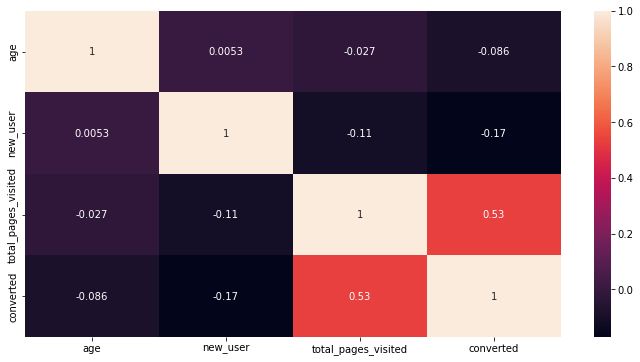

In [205]:
# Heatmap

corr = sumup.corr()
f, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(corr, annot=True, ax=ax)

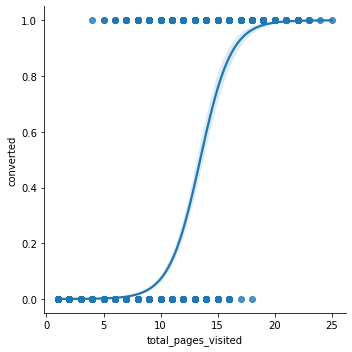

In [206]:
# Coorelation between total pages visited and converted

sns.lmplot(x = 'total_pages_visited' , y = 'converted' , data = sumup, logistic= True)


In [207]:
# Probability increases with the increasing of total pages visited

# Make your model

**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [310]:
# Define X variables and Y target

features_list = ['total_pages_visited']
target_variable = 'converted'

In [311]:
X = sumup.loc[:, features_list]
Y = sumup.loc[:, target_variable]

In [312]:
# train/test set split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

### Training pipeline ###

In [313]:
# Missing values
print("Imputing missing values...")
print(X_train.head())
print()
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
print("...Done!")
print(X_train[:5, :]) 
print() 

# Standardizing numerical features
print("Standardizing numerical features...")
print(X_train[:5, :]) 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
print("...Done")
print(X_train[:5, :]) 
print()

# Label encoding
print("Encoding labels...")
print(Y_train.head())
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("...Done")
print(Y_train[:5])

Imputing missing values...
        total_pages_visited
218344                    7
9015                      1
232993                    3
130789                    5
137309                    6

...Done!
[[7.]
 [1.]
 [3.]
 [5.]
 [6.]]

Standardizing numerical features...
[[7.]
 [1.]
 [3.]
 [5.]
 [6.]]
...Done
[[ 0.64798385]
 [-1.18043451]
 [-0.57096172]
 [ 0.03851106]
 [ 0.34324745]]

Encoding labels...
218344    0
9015      0
232993    0
130789    0
137309    0
Name: converted, dtype: int64
...Done
[0 0 0 0 0]


In [314]:
# Train model
print("Train model...")
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [315]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



### Test pipeline ###

In [316]:
# Missing values
print("Imputing missing values...")
print(X_test.head())
print()
X_test = imputer.transform(X_test)
print("...Done!")
print(X_test[0:5,:]) 
print() 

# Standardizing numerical features
print("Standardizing numerical features...")
print(X_test[0:5,:])
X_test = scaler.transform(X_test)
print("...Done")
print(X_test[0:5,:])
print()

# Label encoding
print("Encoding labels...")
print(Y_test.head())
Y_test = encoder.transform(Y_test)
print("...Done")
print(Y_test[0:5])

Imputing missing values...
        total_pages_visited
62789                     1
126537                   14
7186                     11
8898                      5
60732                     5

...Done!
[[ 1.]
 [14.]
 [11.]
 [ 5.]
 [ 5.]]

Standardizing numerical features...
[[ 1.]
 [14.]
 [11.]
 [ 5.]
 [ 5.]]
...Done
[[-1.18043451]
 [ 2.7811386 ]
 [ 1.86692942]
 [ 0.03851106]
 [ 0.03851106]]

Encoding labels...
62789     0
126537    1
7186      0
8898      0
60732     0
Name: converted, dtype: int64
...Done
[0 1 0 0 0]


In [317]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 1 0 ... 0 0 0]



### Models performance ##

In [318]:
# Print scores

print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.984125
accuracy on test set :  0.9825

f1-score on training set :  0.6817042606516291
f1-score on test set :  0.6534653465346535



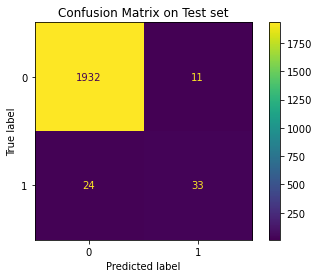

In [319]:
# Visualize confusion matrices

_ , ax = plt.subplots()
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax)
plt.show()

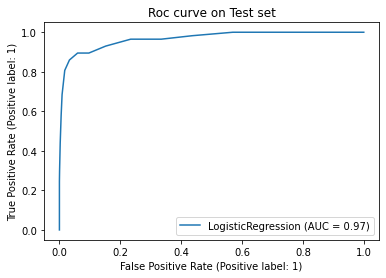

In [320]:
# Visualize ROC curves

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Roc curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(classifier, X_test, Y_test, ax=ax)
plt.show()

**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

In [321]:
# Define X variables and Y target

features_list = ["country","age","new_user","source","total_pages_visited"]
target_variable = 'converted'

In [322]:
X = sumup.loc[:, features_list]
Y = sumup.loc[:, target_variable]


In [323]:
# train/test set split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)

### Training pipeline ###

In [324]:
# Create pipeline for numeric features
numeric_features = [1, 2, 4] # Positions of numeric columns in X_train/X_test
numeric_transformer = Pipeline(steps=[
       ('scaler', StandardScaler())
])


In [325]:
# Create pipeline for categorical features
categorical_features = [0,3] # Positions of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first',handle_unknown='ignore',sparse=False)) # first column will be dropped to avoid creating correlations between features
    ])

In [326]:
# Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train set
print("Performing preprocessings on train set...")
#print(X_train[0:5,:])
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
#print(X_train[0:5,:])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
#print(X_test[0:5,:])
X_test = preprocessor.transform(X_test) # Don't fit again !!
print('...Done.')
#print(X_test[0:5,:])
print()

Performing preprocessings on train set...
...Done.

Performing preprocessings on test set...
...Done.



In [327]:
# Train model
print("Train model...")
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [328]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



### Test pipeline ###

In [329]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



### Models performance ##

In [330]:
# Print scores

print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.987125
accuracy on test set :  0.986

f1-score on training set :  0.743142144638404
f1-score on test set :  0.72



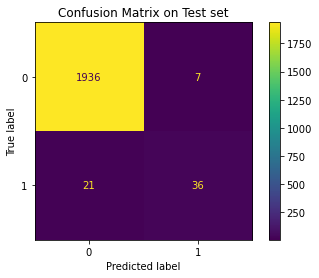

In [331]:
# Visualize confusion matrices

_ , ax = plt.subplots()
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax)
plt.show()

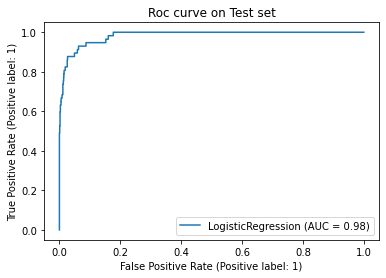

In [332]:
# Visualize ROC curves

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Roc curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(classifier, X_test, Y_test, ax=ax)
plt.show()

In [333]:
# Grid search

## DECISION TREE ##

In [334]:
classifier = DecisionTreeClassifier()
params = {
    'max_depth': [4, 6, 8],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 5) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

...Done.
Best hyperparameters :  {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best validation accuracy :  0.9864999999999998


In [335]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [336]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [337]:
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

f1-score on train set :  0.7333333333333333
f1-score on test set :  0.673913043478261



In [ ]:
# Our result about decision tree is not better than logistic regression with all features

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [338]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

DecisionTreeClassifier()

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ["country","age","new_user","source","total_pages_visited"]
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
[['UK' 28 0 'Seo' 16]
 ['UK' 22 1 'Direct' 5]
 ['China' 32 1 'Seo' 1]
 ['US' 32 1 'Ads' 6]
 ['China' 25 0 'Seo' 3]]


In [344]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")
X_without_labels = preprocessor.transform(X_without_labels)

Encoding categorical features and standardizing numerical features...


/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but OneHotEncoder was fitted with feature names



In [346]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_EXAMPLE.csv', index=False)
Y_predictions

,converted
0,1
1,0
2,0
3,0
4,0
...,...
31615,0
31616,0
31617,0
31618,1


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**